# ELM-BO

In [7]:
import pandas as pd
from pandas import datetime
from sklearn.metrics import mean_squared_error
import math
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.linalg import pinv2
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.linalg import pinv2 
import scipy.stats as stats
from hyperopt import fmin, tpe, hp

def parser(x):
    return datetime.strptime(x,"%Y-%m-%d")
#CHANGE FILE NAME HERE
data = pd.read_csv('Intermediate_Store1.csv', header = 0, parse_dates=[0],index_col=0,squeeze=True, date_parser=parser)
data = np.array(data)
data = np.reshape(data, (-1, 1))
data

C:\Users\koush\anaconda3\envs\LSBU\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


array([[1316],
       [1264],
       [1305],
       ...,
       [2116],
       [2304],
       [2388]], dtype=int64)

In [9]:
def objective(params):
        
        n,lags,w_lo,w_hi,b_lo,b_hi = params['n'], params['lags'],params['w_lo'], params['w_hi'],params['b_lo'], params['b_hi']
        m= lags
        per = (1736 - m)/1826
        size = int(len(data) * per)
        d_train, d_test = data[0:size], data[size:len(data)]

        mean_train = np.mean(d_train)
        sd_train = np.std(d_train)
        d_train = (d_train-mean_train)/sd_train
        d_test = (d_test-mean_train)/sd_train
        X_train = np.array([d_train[i][0] for i in range(m)])
        y_train = np.array(d_train[m][0])

        for i in range(1,(d_train.shape[0]-m)):
            l = np.array([d_train[j][0] for j in range(i,i+m)])
            X_train = np.vstack([X_train,l])
            y_train = np.vstack([y_train,d_train[i+m]])
    
        #auto corrected input vector for test
        X_test = np.array([d_test[i][0] for i in range(m)])
        y_test = np.array(d_test[m][0])

        for i in range(1,(d_test.shape[0]-m)):
            l = np.array([d_test[j][0] for j in range(i,i+m)])
            X_test = np.vstack([X_test,l])
            y_test = np.vstack([y_test,d_test[i+m]])
            
        input_size = X_train.shape[1]
        hidden_size = n   #no. of hidden neurons
        mu, sigma = 0, 1
         #initialising input weights and biases randomly drawn from a truncated normal distribution
        input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma,size=[input_size,hidden_size])
        biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma,size=[hidden_size])
        
        def relu(x):      #hidden layer activation function
            return np.maximum(x, 0, x)
        
        def hidden_nodes(X):
            G = np.dot(X, input_weights)
            G = G + biases
            H = relu(G)
            return H

        output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)

        def predict(X):
            out = hidden_nodes(X)
            out = np.dot(out, output_weights)
            return out

        prediction = predict(X_test)

        # evaluate forecasts
        rmse = math.sqrt(mean_squared_error(y_test, prediction))
    
        return rmse

# Search space definition
space = {
    'n': hp.randint('n', 1, 1826),
    'lags': hp.randint('lags', 1, 275),
    'w_lo': hp.uniform('w_lo', -5, -0.5),
    'w_hi': hp.uniform('w_hi', 0.5, 5),
    'b_lo': hp.uniform('b_lo', -5, -0.5),
    'b_hi': hp.uniform('b_hi', 0.5, 5)
}

# Init the optimizer
# fn: function to be optimized
# space: search space
# algo: optimizer algorithm
# max_evals: number of iterations
best = fmin(
    fn=objective,  
    space=space,
    algo=tpe.suggest,
    max_evals=500
)

print(best)

100%|██████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.34s/trial, best loss: 0.3322862841783991]
{'b_hi': 2.9810558820989432, 'b_lo': -1.5244918787743886, 'lags': 93, 'n': 1033, 'w_hi': 2.209668427999548, 'w_lo': -4.048497599393898}


In [10]:
np.random.seed(1)

def parser(x):
    return datetime.strptime(x,"%Y-%m-%d")

#CHANGE FILE NAME HERE
data = pd.read_csv('Intermediate_Store1.csv', header = 0, parse_dates=[0],index_col=0,squeeze=True, date_parser=parser)
data = np.array(data)
data = np.reshape(data, (-1, 1))
#splitting data into test and train parts, Forecasting demand for last 3 months, (have to consider 3 months + m days to account for input features)
m= best['lags']
per = (1736 - m)/1826
size = int(len(data) * per)
d_train, d_test = data[0:size], data[size:len(data)]

mean_train = np.mean(d_train)
sd_train = np.std(d_train)
d_train = (d_train-mean_train)/sd_train
d_test = (d_test-mean_train)/sd_train

# Converting data into 2d array combining time steps for directly feeding into ELM

#auto corrected input vector for training (we are taking m lagged values as features for each data point)
X_train = np.array([d_train[i][0] for i in range(m)])
y_train = np.array(d_train[m][0])

for i in range(1,(d_train.shape[0]-m)):
    l = np.array([d_train[j][0] for j in range(i,i+m)])
    X_train = np.vstack([X_train,l])
    y_train = np.vstack([y_train,d_train[i+m]])
    
#auto corrected input vector for test
X_test = np.array([d_test[i][0] for i in range(m)])
y_test = np.array(d_test[m][0])

for i in range(1,(d_test.shape[0]-m)):
    l = np.array([d_test[j][0] for j in range(i,i+m)])
    X_test = np.vstack([X_test,l])
    y_test = np.vstack([y_test,d_test[i+m]])
    
best_score, best_input_weights,best_biases = float("inf"), None,None

for i in range(1,100):
    input_size = X_train.shape[1]
    hidden_size = best['n']   #no. of hidden neurons

    w_lo = best['w_lo']
    w_hi = best['w_hi']
    b_lo = best['b_lo']
    b_hi = best['b_hi']
    mu, sigma = 0, 1
    #initialising input weights and biases randomly drawn from a truncated normal distribution
    input_weights = stats.truncnorm.rvs((w_lo - mu) / sigma, (w_hi - mu) / sigma, loc=mu, scale=sigma,size=[input_size,hidden_size])
    biases = stats.truncnorm.rvs((b_lo - mu) / sigma, (b_hi - mu) / sigma, loc=mu, scale=sigma,size=[hidden_size])
    
    def relu(x):      #hidden layer activation function
        return np.maximum(x, 0, x)
    def step(x):
        return np.heaviside(x, 1)
    
    def sigmoid(x):
        return 1/(1+np.exp(-x))    
    
    def gaussian(x):
        return np.exp(-(x*x))
    
    def arctangent(x):
        return np.arctan(x)
    
    def tanh(x):
        return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
    
    def hidden_nodes(X):
        G = np.dot(X, input_weights)
        G = G + biases
        H = relu(G)
        return H

    output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)

    def predict(X):
        out = hidden_nodes(X)
        out = np.dot(out, output_weights)
        return out

    prediction = predict(X_test)
    total = X_test.shape[0]
    
    # evaluate forecasts
    rmse = math.sqrt(mean_squared_error(y_test, prediction))
    print('Test RMSE: %.3f' % rmse)
    mape_sum = 0
    for i,j in zip(y_test,prediction):
        mape_sum = mape_sum + (abs((i-j)/i))
    mape = (mape_sum/total)*100
    mpe_sum = 0
    for i,j in zip(y_test,prediction):
        mpe_sum = mpe_sum + ((i-j)/i)
    mpe = (mpe_sum/total)*100
    print('Test MAPE: %.3f' % mape)
    print('Test MPE: %.3f' % mpe)
    if rmse < best_score:
        best_score, best_input_weights,best_biases = rmse, input_weights,biases
        
print("Best RMSE = ",best_score)

Test RMSE: 0.345
Test MAPE: 97.358
Test MPE: -46.374
Test RMSE: 0.272
Test MAPE: 79.813
Test MPE: 5.187
Test RMSE: 0.305
Test MAPE: 103.803
Test MPE: -17.398
Test RMSE: 0.280
Test MAPE: 72.877
Test MPE: 10.200
Test RMSE: 0.257
Test MAPE: 89.059
Test MPE: -22.492
Test RMSE: 0.292
Test MAPE: 110.330
Test MPE: -42.019
Test RMSE: 0.266
Test MAPE: 83.856
Test MPE: 0.608
Test RMSE: 0.256
Test MAPE: 74.770
Test MPE: -9.286
Test RMSE: 0.258
Test MAPE: 74.026
Test MPE: 37.161
Test RMSE: 0.292
Test MAPE: 76.287
Test MPE: 2.117
Test RMSE: 0.289
Test MAPE: 80.678
Test MPE: 20.908
Test RMSE: 0.287
Test MAPE: 65.420
Test MPE: -21.261
Test RMSE: 0.275
Test MAPE: 76.406
Test MPE: -8.585
Test RMSE: 0.319
Test MAPE: 127.145
Test MPE: -42.313
Test RMSE: 0.264
Test MAPE: 83.556
Test MPE: 11.930
Test RMSE: 0.295
Test MAPE: 69.965
Test MPE: 0.094
Test RMSE: 0.248
Test MAPE: 79.013
Test MPE: 0.814
Test RMSE: 0.286
Test MAPE: 75.401
Test MPE: -17.076
Test RMSE: 0.292
Test MAPE: 104.274
Test MPE: -10.346
Test 

Test RMSE: 136.670
Test MAPE: 4.474
Test MPE: 0.617


([<matplotlib.axis.XTick at 0x1c500e3f2e8>,
 <a list of 5 Text xticklabel objects>)

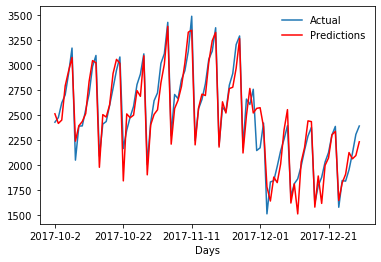

In [11]:
#Making forecasts with best ELM possible


#initialising input weights and biases randomly drawn from a Gaussian distribution
input_weights = best_input_weights
biases = best_biases

def relu(x):      #hidden layer activation function
    return np.maximum(x, 0, x)
def step(x):
    return np.heaviside(x, 1)    
def sigmoid(x):
    return 1/(1+np.exp(-x))
def gaussian(x):
    return np.exp(-(x*x))
def arctangent(x):
    return np.arctan(x)
def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def hidden_nodes(X):
    G = np.dot(X, input_weights)
    G = G + biases
    H = relu(G)
    return H

output_weights = np.dot(pinv2(hidden_nodes(X_train)), y_train)

def predict(X):
    out = hidden_nodes(X)
    out = np.dot(out, output_weights)
    return out

prediction = predict(X_test)
total = X_test.shape[0]

y_test = (y_test*sd_train) + mean_train
prediction = (prediction*sd_train) + mean_train

# evaluate forecasts
rmse = math.sqrt(mean_squared_error(y_test, prediction))
print('Test RMSE: %.3f' % rmse)
mape_sum = 0
for i,j in zip(y_test,prediction):
    mape_sum = mape_sum + (abs((i-j)/i))
mape = (mape_sum/total)*100
mpe_sum = 0
for i,j in zip(y_test,prediction):
    mpe_sum = mpe_sum + ((i-j)/i)
mpe = (mpe_sum/total)*100
print('Test MAPE: %.3f' % mape)
print('Test MPE: %.3f' % mpe)

# plot forecasts against actual outcomes
fig, ax = plt.subplots()
ax.plot(y_test,label = 'Actual')
ax.plot(prediction, color='red',label = 'Predictions')
ax.legend(loc='upper right', frameon=False)
plt.xlabel('Days')
plt.ylabel('Sales Data')
plt.title('ELM-BO with Test RMSE: '+str(rmse)+ ' ,Test MAPE: '+str(mape[0])+' ,Test MPE: '+str(mpe[0]))
plt.xticks([0,20,40,60,80],['2017-10-02','2017-10-22','2017-11-11','2017-12-01','2017-12-21'])
plt.savefig('ELM-BO plot of Store1.png')  #CHANGE STORE NUMBER HERE